Problem Statement

Amazon is an online shopping website that now caters to millions of people everywhere. Over 34,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output


from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/ecommerce/train_data.csv")
test = pd.read_csv("../input/ecommerce/test_data.csv")

In [3]:
train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [4]:

test.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [5]:
train.count()

name                 4000
brand                4000
categories           4000
primaryCategories    4000
reviews.date         4000
reviews.text         4000
reviews.title        3990
sentiment            4000
dtype: int64

In [6]:
#train = train.append(test, ignore_index=True)
test.count()

name                 1000
brand                1000
categories           1000
primaryCategories    1000
reviews.date         1000
reviews.text         1000
reviews.title         997
dtype: int64

In [7]:
train.duplicated().sum()

58

There are 58 duplicates, let's drop the duplicate values

In [8]:
train = train.drop_duplicates().reset_index(drop=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 8 columns):
name                 3942 non-null object
brand                3942 non-null object
categories           3942 non-null object
primaryCategories    3942 non-null object
reviews.date         3942 non-null object
reviews.text         3942 non-null object
reviews.title        3932 non-null object
sentiment            3942 non-null object
dtypes: object(8)
memory usage: 246.5+ KB


In [10]:
train.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [11]:
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,3942,3942,3942,3942,3942,3942,3932,3942
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,Got this for my Daughter-in-Law and she loves ...,Great tablet,Positive
freq,676,3942,628,2562,98,4,99,3694


Lets Visualize with the class imbalance thing !

# Basic EDA of trainig data set

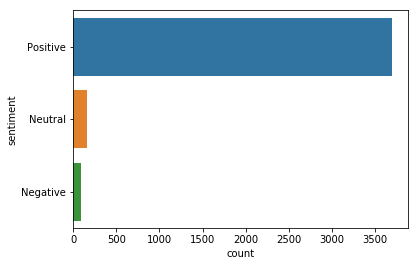

In [12]:
sns.countplot(y=train.sentiment);

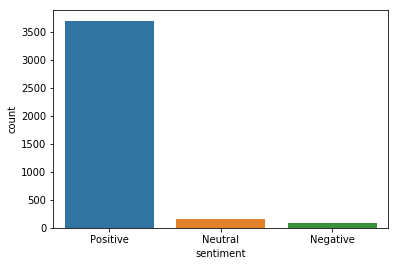

In [13]:
sns.countplot( train['sentiment']);

### Class Imbalance Problem

In [14]:
train.sentiment.value_counts()

Positive    3694
Neutral      158
Negative      90
Name: sentiment, dtype: int64

In [15]:
# NA data
train.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [16]:
test.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

We should rename the column to avoid errors

In [17]:
train.columns

Index(['name', 'brand', 'categories', 'primaryCategories', 'reviews.date',
       'reviews.text', 'reviews.title', 'sentiment'],
      dtype='object')

In [18]:
train.rename(columns = {'reviews.text':'reviews_text', 'reviews.title':'reviews_title','reviews.date':'reviews_date'}, inplace = True)

In [19]:
train.columns

Index(['name', 'brand', 'categories', 'primaryCategories', 'reviews_date',
       'reviews_text', 'reviews_title', 'sentiment'],
      dtype='object')

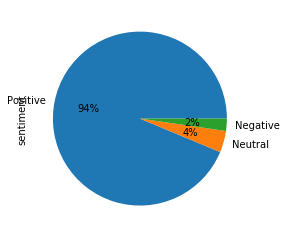

In [20]:
train['sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')

Here I am dropping the Neutral Sentiment as My goal is to work on differentiate the positive and negative 

In [21]:
train = train[train.sentiment != "Neutral"]

### Now we are ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative sentiment.

Positive words


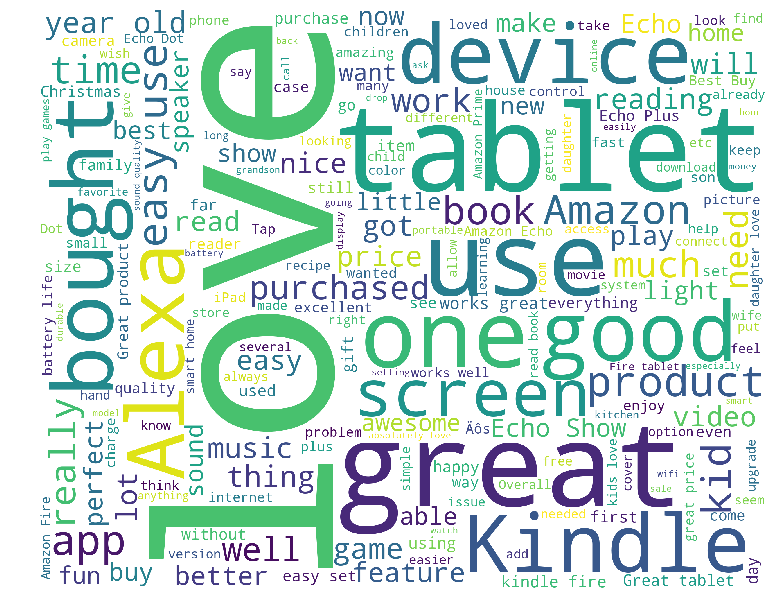

Negative words


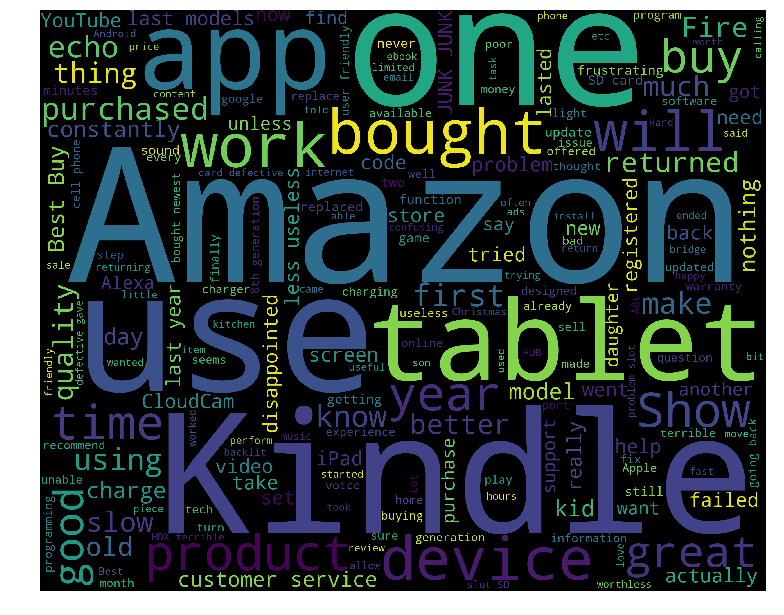

In [22]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['reviews_text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['reviews_text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

# Data Preprocessing Part

#  Stopword Removal using NLTK

After the vizualization, we need to remove the hashtags, mentions, links and stopwords from the training set.

Stop Word: Stop Words are words which do not contain important significance to be used in Search Queries. Usually these words are filtered out from search queries because they return vast amount of unnecessary information. ( the, for, this etc. )

In [23]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

In [24]:
# First step - tokenizing phrases
train['reviews_text'] = train['reviews_text'].apply(nltk.word_tokenize)

# Second step - passing through prep functions
#train['reviews_text'] = train['reviews_text'].apply(normalize) 
train['reviews_text'].head()

0    [Purchased, on, Black, FridayPros, -, Great, P...
1    [I, purchased, two, Amazon, in, Echo, Plus, an...
3    [very, good, product, ., Exactly, what, I, wan...
4    [This, is, the, 3rd, one, I, 've, purchased, ....
5    [This, is, a, great, product, ., Light, weight...
Name: reviews_text, dtype: object

Let's visualize the most common keywords

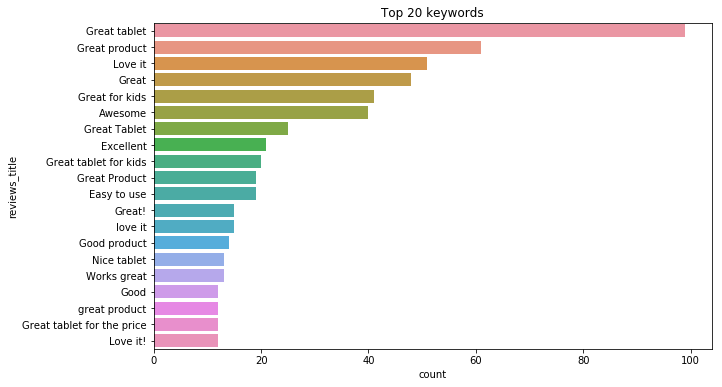

In [25]:
# Most common keywords
plt.figure(figsize=(10,6))
sns.countplot(y=train.reviews_title, order = train.reviews_title.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()
# train.keyword.value_counts().head(10)